5.1 야후 파이낸스와 네이버 금융 비교하기

-그래프를 그려서 비교해보자.
-Data visualization을 거치면 시각적으로 좋고 새로운 정보를 알 수 있다.

-삼성전자 데이터를 2017년 1/1 부터 조회  
-2행 1열 첫번째 영역 선택  
-삼성전자 종가를 청록색 실선  
-삼성전자 수정종가를 파란색 점선  
-2행 1열 두번째 영역 선택  
-삼성전자 거래량을 바 차트로 그림.  

[*********************100%***********************]  1 of 1 completed


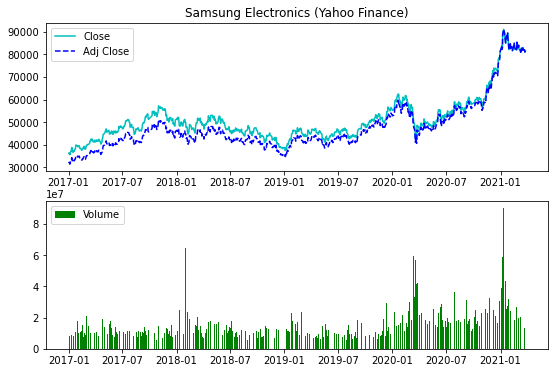

In [1]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
import matplotlib.pyplot as plt

df = pdr.get_data_yahoo('005930.KS', '2017-01-01')  # ①

plt.figure(figsize=(9, 6))
plt.subplot(2, 1, 1)  # ② 
plt.title('Samsung Electronics (Yahoo Finance)')
plt.plot(df.index, df['Close'], 'c', label='Close')  # ③
plt.plot(df.index, df['Adj Close'], 'b--', label='Adj Close')  # ④
plt.legend(loc='best')
plt.subplot(2, 1, 2)  # ⑤
plt.bar(df.index, df['Volume'], color='g', label='Volume')  # ⑥
plt.legend(loc='best')
plt.show()

1. 한국 주식 종목들의 데이터는 종가 및 수정 종가가 정확하지 않다. 
2. 한국 주식 종목들은 2017년 10월에 3주 가량 비었다.

---이처럼 데이터가 잘못되면 실제 투자에 활용할 수 없다. 부정확한 야후 파이낸스 대신 네이버 금융의 주식 데이터를 스크레이핑해서 데이터 베이스를 구축한 뒤, 이를 언제든지 조회 가능한 시세 조회 API를 만들어보자.

In [5]:
import matplotlib.pyplot as plt
from Investar import Analyzer  # ①

mk = Analyzer.MarketDB()  # ②
df = mk.get_daily_price('005930', '2017-07-10', '2018-06-30')  # ③

plt.figure(figsize=(9, 6))
plt.subplot(2, 1, 1)
plt.title('Samsung Electronics (Investar Data)')
plt.plot(df.index, df['close'], 'c', label='Close')  # ④
plt.legend(loc='best')
plt.subplot(2, 1, 2)
plt.bar(df.index, df['volume'], color='g', label='Volume')
plt.legend(loc='best')
plt.show()

OperationalError: (2003, "Can't connect to MySQL server on 'localhost' ([WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다)")

# pymysql 라이브러리

파이썬 프로그램 내부에서 마리아디비를 사용하기 위한 라이브러리 
-> 

In [3]:
import pymysql

connection = pymysql.connect(host='localhost', port=3306, db='Investar', 
    user='root', passwd='000623becky', autocommit=True)  

cursor = connection.cursor()
cursor.execute("SELECT VERSION();")
result = cursor.fetchone()

print ("MariaDB version : {}".format(result))

connection.close()

MariaDB version : ('10.5.9-MariaDB',)


# 5.3 주식 시세를 매일 DB로 업데이트하기

## 5.3.1 DBUpdater 클래스 구조

In [ ]:
import pandas as pd
from bs4 import BeautifulSoup
import urllib, pymysql, calendar, time, json
from urllib.request import urlopen
from datetime import datetime
from threading import Timer

class DBUpdater:  
    def __init__(self):
        """생성자: MariaDB 연결 및 종목코드 딕셔너리 생성"""
        self.conn = pymysql.connect(host='localhost', user='root',
            password='000623becky', db='INVESTAR', charset='utf8')
        
        with self.conn.cursor() as curs:
            sql = """
            CREATE TABLE IF NOT EXISTS company_info (
                code VARCHAR(20),
                company VARCHAR(40),
                last_update DATE,
                PRIMARY KEY (code))
            """
            curs.execute(sql)
            sql = """
            CREATE TABLE IF NOT EXISTS daily_price (
                code VARCHAR(20),
                date DATE,
                open BIGINT(20),
                high BIGINT(20),
                low BIGINT(20),
                close BIGINT(20),
                diff BIGINT(20),
                volume BIGINT(20),
                PRIMARY KEY (code, date))
            """
            curs.execute(sql)
        self.conn.commit()
        self.codes = dict()
               
    def __del__(self):
        """소멸자: MariaDB 연결 해제"""
        self.conn.close() 
     
    def read_krx_code(self):
        """KRX로부터 상장기업 목록 파일을 읽어와서 데이터프레임으로 반환"""
        url = 'http://kind.krx.co.kr/corpgeneral/corpList.do?method='\
            'download&searchType=13'
        krx = pd.read_html(url, header=0)[0]
        krx = krx[['종목코드', '회사명']]
        krx = krx.rename(columns={'종목코드': 'code', '회사명': 'company'})
        krx.code = krx.code.map('{:06d}'.format)
        return krx
    
    def update_comp_info(self):
        """종목코드를 company_info 테이블에 업데이트 한 후 딕셔너리에 저장"""
        sql = "SELECT * FROM company_info"
        df = pd.read_sql(sql, self.conn)
        for idx in range(len(df)):
            self.codes[df['code'].values[idx]] = df['company'].values[idx]
                    
        with self.conn.cursor() as curs:
            sql = "SELECT max(last_update) FROM company_info"
            curs.execute(sql)
            rs = curs.fetchone()
            today = datetime.today().strftime('%Y-%m-%d')
            if rs[0] == None or rs[0].strftime('%Y-%m-%d') < today:
                krx = self.read_krx_code()
                for idx in range(len(krx)):
                    code = krx.code.values[idx]
                    company = krx.company.values[idx]                
                    sql = f"REPLACE INTO company_info (code, company, last"\
                        f"_update) VALUES ('{code}', '{company}', '{today}')"
                    curs.execute(sql)
                    self.codes[code] = company
                    tmnow = datetime.now().strftime('%Y-%m-%d %H:%M')
                    print(f"[{tmnow}] #{idx+1:04d} REPLACE INTO company_info "\
                        f"VALUES ({code}, {company}, {today})")
                self.conn.commit()
                print('')              

    def read_naver(self, code, company, pages_to_fetch):
        """네이버에서 주식 시세를 읽어서 데이터프레임으로 반환"""
        try:
            url = f"http://finance.naver.com/item/sise_day.nhn?code={code}"
            with urlopen(url) as doc:
                if doc is None:
                    return None
                html = BeautifulSoup(doc, "lxml")
                pgrr = html.find("td", class_="pgRR")
                if pgrr is None:
                    return None
                s = str(pgrr.a["href"]).split('=')
                lastpage = s[-1] 
            df = pd.DataFrame()
            pages = min(int(lastpage), pages_to_fetch)
            for page in range(1, pages + 1):
                pg_url = '{}&page={}'.format(url, page)
                df = df.append(pd.read_html(pg_url, header=0)[0])
                tmnow = datetime.now().strftime('%Y-%m-%d %H:%M')
                print('[{}] {} ({}) : {:04d}/{:04d} pages are downloading...'.
                    format(tmnow, company, code, page, pages), end="\r")
            df = df.rename(columns={'날짜':'date','종가':'close','전일비':'diff'
                ,'시가':'open','고가':'high','저가':'low','거래량':'volume'})
            df['date'] = df['date'].replace('.', '-')
            df = df.dropna()
            df[['close', 'diff', 'open', 'high', 'low', 'volume']] = df[['close',
                'diff', 'open', 'high', 'low', 'volume']].astype(int)
            df = df[['date', 'open', 'high', 'low', 'close', 'diff', 'volume']]
        except Exception as e:
            print('Exception occured :', str(e))
            return None
        return df

    def replace_into_db(self, df, num, code, company):
        """네이버에서 읽어온 주식 시세를 DB에 REPLACE"""
        with self.conn.cursor() as curs:
            for r in df.itertuples():
                sql = f"REPLACE INTO daily_price VALUES ('{code}', "\
                    f"'{r.date}', {r.open}, {r.high}, {r.low}, {r.close}, "\
                    f"{r.diff}, {r.volume})"
                curs.execute(sql)
            self.conn.commit()
            print('[{}] #{:04d} {} ({}) : {} rows > REPLACE INTO daily_'\
                'price [OK]'.format(datetime.now().strftime('%Y-%m-%d'\
                ' %H:%M'), num+1, company, code, len(df)))

    def update_daily_price(self, pages_to_fetch):
        """KRX 상장법인의 주식 시세를 네이버로부터 읽어서 DB에 업데이트"""  
        for idx, code in enumerate(self.codes):
            df = self.read_naver(code, self.codes[code], pages_to_fetch)
            if df is None:
                continue
            self.replace_into_db(df, idx, code, self.codes[code])            

    def execute_daily(self):
        """실행 즉시 및 매일 오후 다섯시에 daily_price 테이블 업데이트"""
        self.update_comp_info()
        
        try:
            with open('config.json', 'r') as in_file:
                config = json.load(in_file)
                pages_to_fetch = config['pages_to_fetch']
        except FileNotFoundError:
            with open('config.json', 'w') as out_file:
                pages_to_fetch = 100 
                config = {'pages_to_fetch': 1}
                json.dump(config, out_file)
        self.update_daily_price(pages_to_fetch)

        tmnow = datetime.now()
        lastday = calendar.monthrange(tmnow.year, tmnow.month)[1]
        if tmnow.month == 12 and tmnow.day == lastday:
            tmnext = tmnow.replace(year=tmnow.year+1, month=1, day=1,
                hour=17, minute=0, second=0)
        elif tmnow.day == lastday:
            tmnext = tmnow.replace(month=tmnow.month+1, day=1, hour=17,
                minute=0, second=0)
        else:
            tmnext = tmnow.replace(day=tmnow.day+1, hour=17, minute=0,
                second=0)   
        tmdiff = tmnext - tmnow
        secs = tmdiff.seconds
        t = Timer(secs, self.execute_daily)
        print("Waiting for next update ({}) ... ".format(tmnext.strftime
            ('%Y-%m-%d %H:%M')))
        t.start()

if __name__ == '__main__':
    dbu = DBUpdater()
    dbu.execute_daily()


# 5.4 일별 시세 조회 API

In [8]:
import pandas as pd
import pymysql
from datetime import datetime
from datetime import timedelta
import re

class MarketDB:
    def __init__(self):
        """생성자: MariaDB 연결 및 종목코드 딕셔너리 생성"""
        self.conn = pymysql.connect(host='localhost', user='root', 
            password='000623becky', db='INVESTAR', charset='utf8')
        self.codes = {}
        self.get_comp_info()
        
    def __del__(self):
        """소멸자: MariaDB 연결 해제"""
        self.conn.close()

    def get_comp_info(self):
        """company_info 테이블에서 읽어와서 codes에 저장"""
        sql = "SELECT * FROM company_info"
        krx = pd.read_sql(sql, self.conn)
        for idx in range(len(krx)):
            self.codes[krx['code'].values[idx]] = krx['company'].values[idx]

    def get_daily_price(self, code, start_date=None, end_date=None):
        """KRX 종목의 일별 시세를 데이터프레임 형태로 반환
            - code       : KRX 종목코드('005930') 또는 상장기업명('삼성전자')
            - start_date : 조회 시작일('2020-01-01'), 미입력 시 1년 전 오늘
            - end_date   : 조회 종료일('2020-12-31'), 미입력 시 오늘 날짜
        """
        if start_date is None:
            one_year_ago = datetime.today() - timedelta(days=365)
            start_date = one_year_ago.strftime('%Y-%m-%d')
            print("start_date is initialized to '{}'".format(start_date))
        else:
            start_lst = re.split('\D+', start_date)
            if start_lst[0] == '':
                start_lst = start_lst[1:]
            start_year = int(start_lst[0])
            start_month = int(start_lst[1])
            start_day = int(start_lst[2])
            if start_year < 1900 or start_year > 2200:
                print(f"ValueError: start_year({start_year:d}) is wrong.")
                return
            if start_month < 1 or start_month > 12:
                print(f"ValueError: start_month({start_month:d}) is wrong.")
                return
            if start_day < 1 or start_day > 31:
                print(f"ValueError: start_day({start_day:d}) is wrong.")
                return
            start_date=f"{start_year:04d}-{start_month:02d}-{start_day:02d}"

        if end_date is None:
            end_date = datetime.today().strftime('%Y-%m-%d')
            print("end_date is initialized to '{}'".format(end_date))
        else:
            end_lst = re.split('\D+', end_date)
            if end_lst[0] == '':
                end_lst = end_lst[1:] 
            end_year = int(end_lst[0])
            end_month = int(end_lst[1])
            end_day = int(end_lst[2])
            if end_year < 1800 or end_year > 2200:
                print(f"ValueError: end_year({end_year:d}) is wrong.")
                return
            if end_month < 1 or end_month > 12:
                print(f"ValueError: end_month({end_month:d}) is wrong.")
                return
            if end_day < 1 or end_day > 31:
                print(f"ValueError: end_day({end_day:d}) is wrong.")
                return
            end_date = f"{end_year:04d}-{end_month:02d}-{end_day:02d}"
         
        codes_keys = list(self.codes.keys())
        codes_values = list(self.codes.values())

        if code in codes_keys:
            pass
        elif code in codes_values:
            idx = codes_values.index(code)
            code = codes_keys[idx]
        else:
            print(f"ValueError: Code({code}) doesn't exist.")
        sql = f"SELECT * FROM daily_price WHERE code = '{code}'"\
            f" and date >= '{start_date}' and date <= '{end_date}'"
        df = pd.read_sql(sql, self.conn)
        df.index = df['date']
        return df 

